In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.autograd import grad
import scipy.linalg as sp

from scipy.stats import norm
import math
import numpy as np
import os
import time
from numpy import save
from numpy import load

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

The 1D Allen-Cahn equation is given by

$$
\frac{\partial u}{\partial t} = \epsilon \frac{\partial^2 u}{\partial x^2} + u - u^3
$$

We solve for $x \in [0,2\pi], t \in [0, 5],$ with $\epsilon=0.001,$ subject to Dirichlet boundary conditions

$$
u(0,t) = 0 \\
u(2\pi,t) = 0
$$

and the initial condition

$$
u(x,0) = 0.25\sin(x) 
$$

In [2]:
def fft_allen_cahn(x, t, epsilon):
    
    nx, nt = len(x), len(t)
    dt=0.001
    v=0.25*np.sin(x)
    k = np.arange(0,nx/2)
    k = np.append(k, 0)
    k = np.concatenate((k, np.arange(-nx/2+1,0)))
    k = k*1j
    k2=np.real(np.square(k))
    tmax=np.max(t)
    tplot=tmax/(nt-1)
    plotgap=int(np.round(tplot/dt))
    nplots=int(np.round(tmax/tplot))
    data = np.zeros((nplots+1,nx))
    data[0,:] = v

    for i in np.arange(1,nplots+1):
        for n in np.arange(1,plotgap+1):
            v_hat = np.fft.fft(v) # converts to Fourier space
            vv = np.power(v, 3) # computes nonlinear term in real space
            vv = np.fft.fft(vv) # converts nonlinear term to Fourier space
            v_hat = np.divide(v_hat*(1/dt+1)-vv, 1/dt-k2*epsilon) # Implicit / Explicit
            v = np.fft.ifft(v_hat)
        data[i,:] = np.real(v)
    
    return data

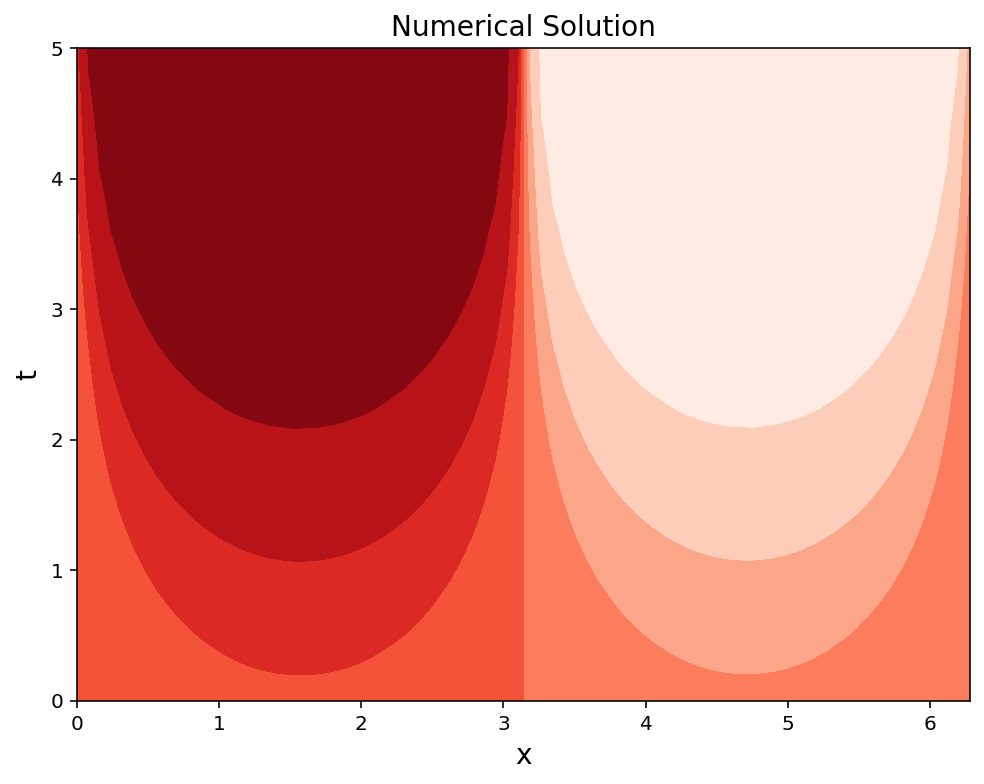

In [3]:
# define x-axis and t-axis
x_axis_num = np.linspace(0, 2*np.pi, 80)
t_axis_num = np.linspace(0, 5, 26)
sol = fft_allen_cahn(x_axis_num, t_axis_num, 0.001)
x_grid_num, t_grid_num = np.meshgrid(x_axis_num, t_axis_num)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Numerical Solution', fontsize=14)
ax.set_xlabel('x', fontsize=14), ax.set_ylabel('t', fontsize=14)
cf = ax.contourf(x_grid_num, t_grid_num, sol, cmap="Reds")

In [4]:
def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

In [5]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

In [6]:
class MLP_2D(nn.Module):
    
    def __init__(self, equation, init_cond):
        super().__init__()
        self.equation = equation
        
        # initial & boundary conditions: IBVP1D (Dirichlet-Dirichlet)
        self.t_min, self.t_min_val, self.x_min, self.x_min_val, self.x_max, self.x_max_val = init_cond
        
        # add layers
        self.hidden1 = nn.Linear(2,80)
        self.hidden2 = nn.Linear(80,80)
        self.hidden3 = nn.Linear(80,80)
        self.hidden4 = nn.Linear(80,40)
        self.out = nn.Linear(40,1)
        self.tn = nn.Tanh()
        self.layers = nn.ModuleList([self.hidden1, self.hidden2, self.hidden3, self.hidden4, self.out])
        
    def forward(self, x, t):
        # do forward pass
        u = torch.cat((x, t), 1)
        u = self.hidden1(u)
        for l in self.layers[1:]:
            u = l(self.tn(u))
        
        # re-parametrize (for IBVP1D (Dirichlet-Dirichlet))
        x_tilde = (x - self.x_min)/(self.x_max - self.x_min)
        t_tilde = t - self.t_min
        t0 = self.t_min*torch.ones_like(t, requires_grad=True)
        Axt = self.t_min_val(x) + \
              x_tilde*(self.x_max_val(t) - self.x_max_val(t0)) + \
              (1 - x_tilde)*(self.x_min_val(t) - self.x_min_val(t0))
        
        # enforce initial conditions (for IBVP1D (Dirichlet-Dirichlet))
        u = Axt + x_tilde*(1 - x_tilde)*(1 - torch.exp(-t_tilde))*u
        return u
    
    def simple_loss(self, x, t):
        u_tilde = self(x, t)
        u_t_tilde = nth_derivative(flat(u_tilde), wrt=t, n=1)
        u_x_tilde = nth_derivative(flat(u_tilde), wrt=x, n=1)
        u_xx_tilde = nth_derivative(flat(u_x_tilde), wrt=x, n=1)
        res_tilde = self.equation(u_tilde, u_t_tilde, u_xx_tilde)
        loss = (res_tilde**2).mean()
        return loss

In [7]:
# specify training domain
x_min = 0.0
x_max = 2*np.pi
t_min = 0.0 
t_max = 5.0

# specify number of training points
nx = 64
nt = 64

# generate training points 
x = torch.linspace(x_min, x_max, nx, requires_grad=True)
t = torch.linspace(t_min, t_max, nt, requires_grad=True)
grid_x, grid_t = torch.meshgrid(x, t)
x_train, t_train = grid_x.flatten().unsqueeze(0).t(), grid_t.flatten().unsqueeze(0).t()

# initial conditions
init_cond = (t_min, lambda x: 0.25*torch.sin(x), x_min, lambda t: torch.zeros_like(t), x_max, lambda t: torch.zeros_like(t))

# differential equation (Allen-Cahn equation)
equation = lambda u, u_t, u_xx: u_t - 0.001*u_xx - u + u**3

# instantiate network
model_2D = MLP_2D(equation, init_cond)
#model_2D.load_state_dict(torch.load('weights_allen_cahn.t.45'))

In [8]:
# train the model

# choose optimizer
optimizer = optim.SGD(model_2D.parameters(), lr=0.012, momentum=0.88, nesterov=True)

# train
epochs = 20000
loss_vals = []
for epoch in range(epochs):
    
    loss = model_2D.simple_loss(x_train, t_train)
    
    optimizer.zero_grad()
    loss.backward()
    loss_vals.append(loss.item())
    optimizer.step()
    
    if epoch % 1000 == 0:
        with torch.no_grad():
            print(f'Epoch: {epoch + 1} Loss: {loss.item()}')

Epoch: 1 Loss: 0.028575731441378593
Epoch: 1001 Loss: 0.013950339518487453
Epoch: 2001 Loss: 0.012863246724009514
Epoch: 3001 Loss: 0.012708167545497417
Epoch: 4001 Loss: 0.012640489265322685
Epoch: 5001 Loss: 0.012605463154613972
Epoch: 6001 Loss: 0.012585374526679516
Epoch: 7001 Loss: 0.012572930194437504
Epoch: 8001 Loss: 0.012564713135361671
Epoch: 9001 Loss: 0.012558970600366592
Epoch: 10001 Loss: 0.012554733082652092
Epoch: 11001 Loss: 0.012551452964544296
Epoch: 12001 Loss: 0.012548799626529217
Epoch: 13001 Loss: 0.012546578422188759
Epoch: 14001 Loss: 0.012544665485620499
Epoch: 15001 Loss: 0.012542977929115295
Epoch: 16001 Loss: 0.012541460804641247
Epoch: 17001 Loss: 0.012540079653263092
Epoch: 18001 Loss: 0.012538805603981018
Epoch: 19001 Loss: 0.012537612579762936


In [65]:
## save/load weights

torch.save(model_2D.state_dict(), 'weights_allen_cahn.t.44')
#model_2D.load_state_dict(torch.load('weights_allen_cahn.t7'))

In [9]:
# prepare for plotting

# specify domain
x_min_p = 0.0
x_max_p = 2*np.pi
t_min_p = 0.0
t_max_p = 5.0

# specify number of points
nx_p = 8000
nt_p = 100

# define x-axis and t-axis
x_axis = np.linspace(x_min_p, x_max_p, nx_p)
t_axis = np.linspace(t_min_p, t_max_p, nt_p)
sol = fft_allen_cahn(x_axis, t_axis, 0.001)
x_grid, t_grid = np.meshgrid(x_axis, t_axis)

# x-axis and t-axis as torch tensors
x_axis_tch = torch.from_numpy(x_axis).float().reshape(nx_p, 1, 1)
t_axis_tch = torch.from_numpy(t_axis).float().reshape(nt_p, 1, 1)

# get the solution matrix
u_nn = np.zeros((nx_p, nt_p))
for i in range(0, nx_p):
    for j in range(0, nt_p):
        u_nn[i][j] = model_2D(x_axis_tch[i], t_axis_tch[j]).detach().numpy()

TypeError: Shapes of x (26, 80) and z (100, 8000) do not match

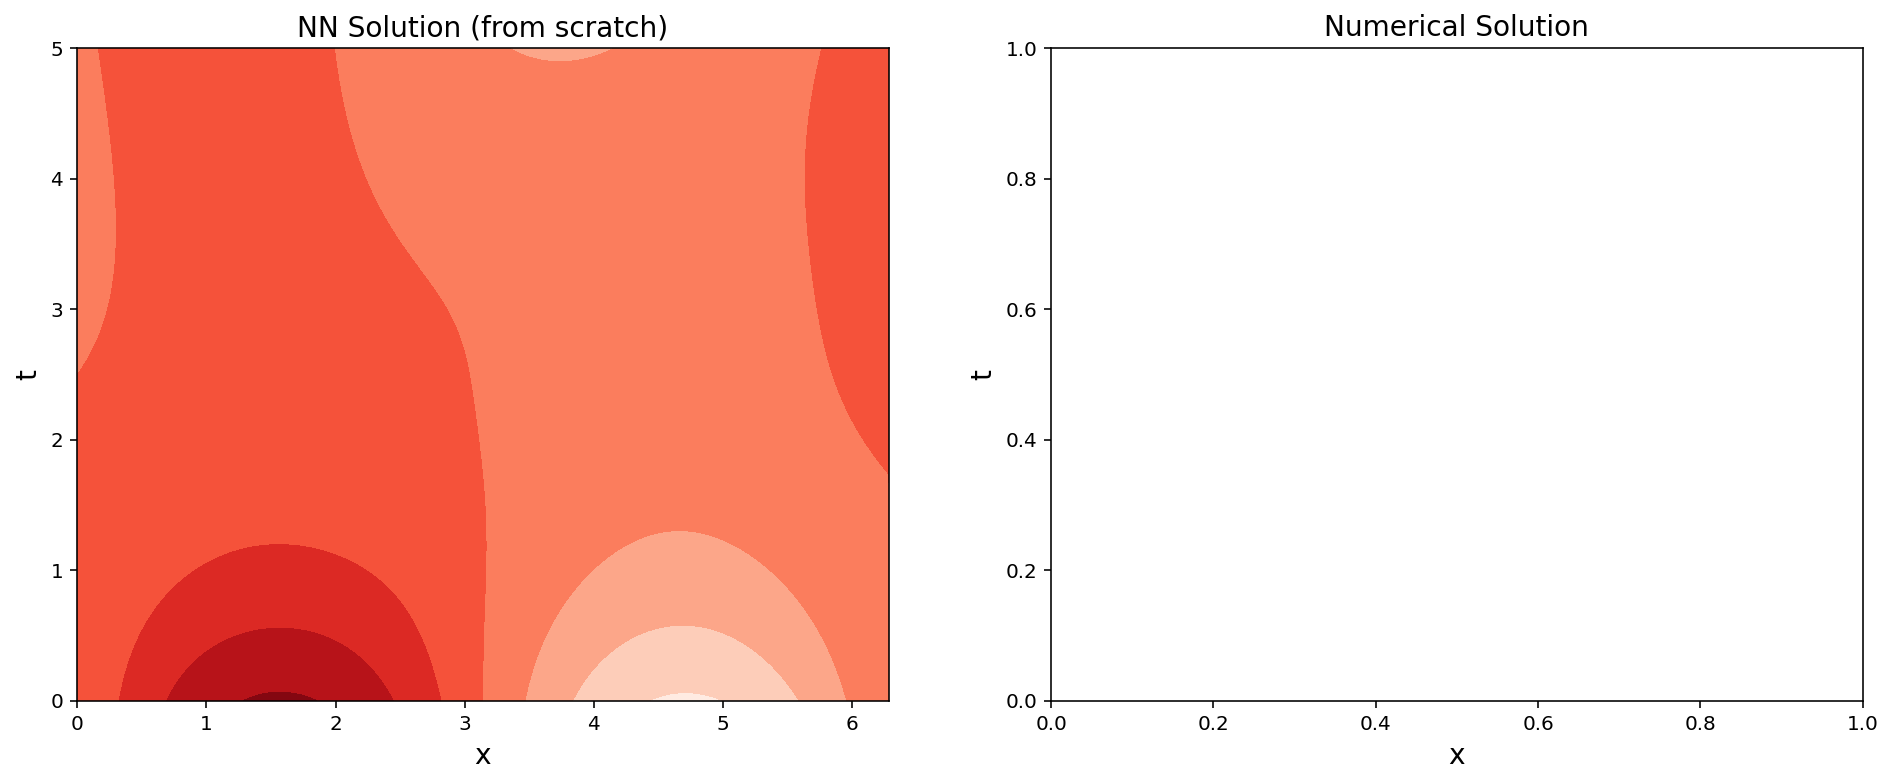

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].set_title('NN Solution (from scratch)', fontsize=14)
cf1 = ax[0].contourf(x_grid, t_grid, u_nn.T, cmap="Reds")
ax[0].set_xlabel('x', fontsize=14), ax[0].set_ylabel('t', fontsize=14)
ax[1].set_title('Numerical Solution', fontsize=14)
ax[1].set_xlabel('x', fontsize=14), ax[1].set_ylabel('t', fontsize=14)
cf2 = ax[1].contourf(x_grid_num, t_grid_num, sol, cmap="Reds")

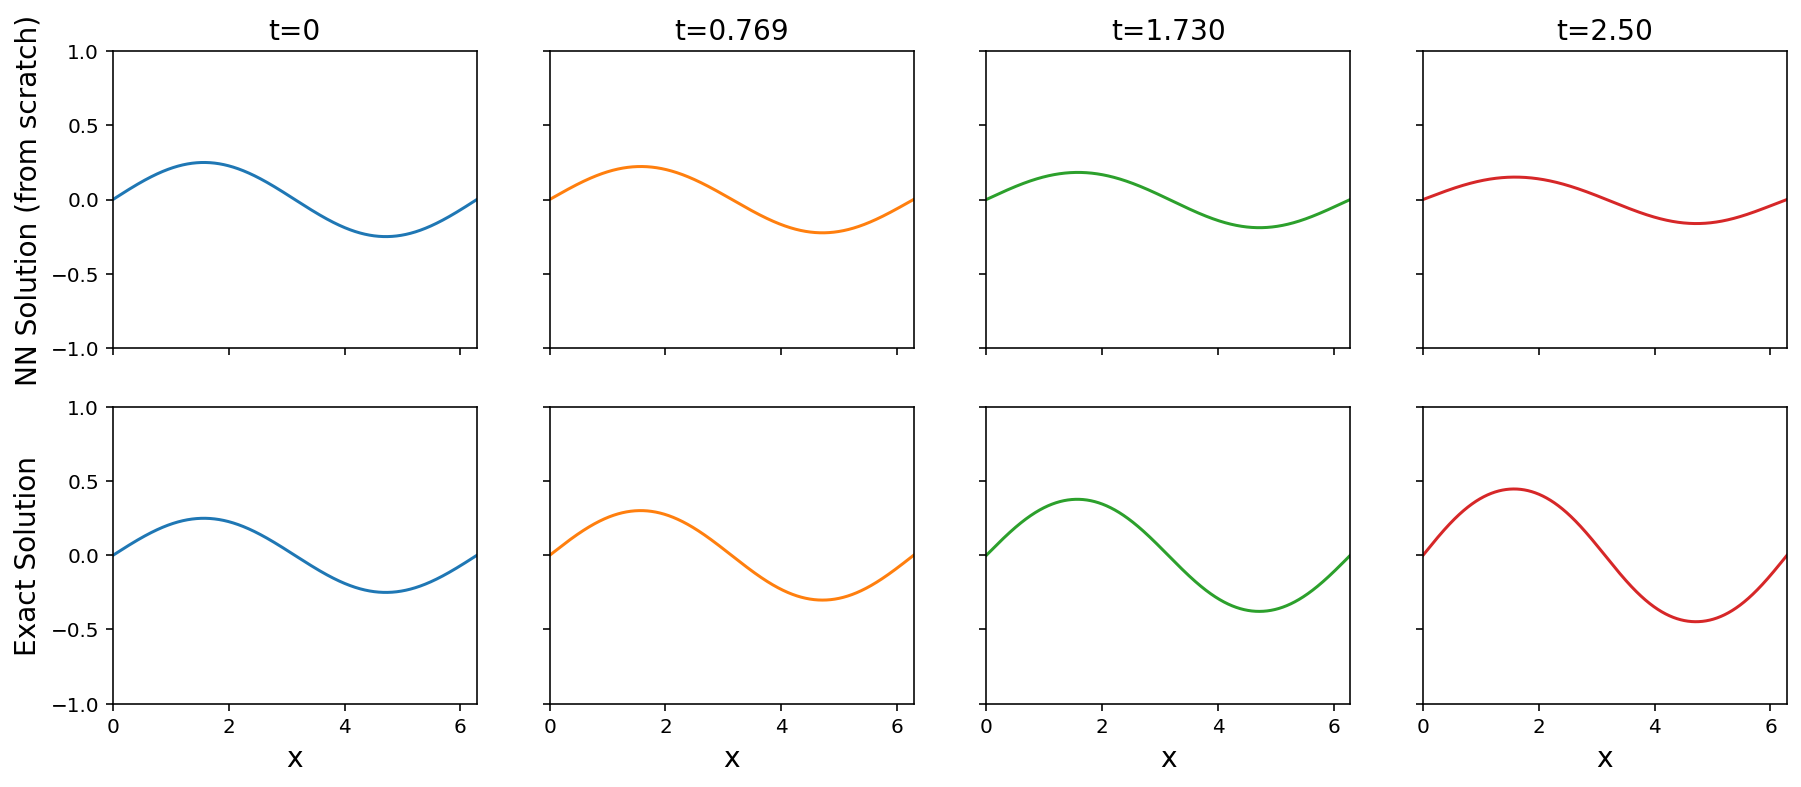

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(15,6))
axs[0, 0].plot(x_axis, u_nn[:,0], 'tab:blue'), axs[0, 0].set_xlim([x_min_p,x_max_p]), axs[0, 0].set_ylim([-1,1]), axs[0, 0].set_title('t=0', fontsize=14)
axs[0, 1].plot(x_axis, u_nn[:,4], 'tab:orange'), axs[0, 1].set_xlim([x_min_p,x_max_p]), axs[0, 1].set_ylim([-1,1]), axs[0, 1].set_title('t=0.769', fontsize=14)
axs[0, 2].plot(x_axis, u_nn[:,9], 'tab:green'), axs[0, 2].set_xlim([x_min_p,x_max_p]), axs[0, 2].set_ylim([-1,1]), axs[0, 2].set_title('t=1.730', fontsize=14)
axs[0, 3].plot(x_axis, u_nn[:,13], 'tab:red'), axs[0, 3].set_xlim([x_min_p,x_max_p]), axs[0, 3].set_ylim([-1,1]), axs[0, 3].set_title('t=2.50', fontsize=14)
axs[1, 0].plot(x_axis, sol.T[:,0], 'tab:blue'), axs[1, 0].set_xlim([x_min_p,x_max_p]), axs[1, 0].set_ylim([-1,1])
axs[1, 1].plot(x_axis, sol.T[:,4], 'tab:orange'), axs[1, 1].set_xlim([x_min_p,x_max_p]), axs[1, 1].set_ylim([-1,1])
axs[1, 2].plot(x_axis, sol.T[:,9], 'tab:green'), axs[1, 2].set_xlim([x_min_p,x_max_p]), axs[1, 2].set_ylim([-1,1])
axs[1, 3].plot(x_axis, sol.T[:,13], 'tab:red'), axs[1, 3].set_xlim([x_min_p,x_max_p]), axs[1, 3].set_ylim([-1,1])
for ax in axs.flat:
    ax.set_xlabel('x', fontsize=14)
for ax in axs[0, :]:
    ax.set_ylabel('NN Solution (from scratch)', fontsize=14)
for ax in axs[1, :]:
    ax.set_ylabel('Exact Solution', fontsize=14)
for ax in axs.flat:
    ax.label_outer()
plt.show()

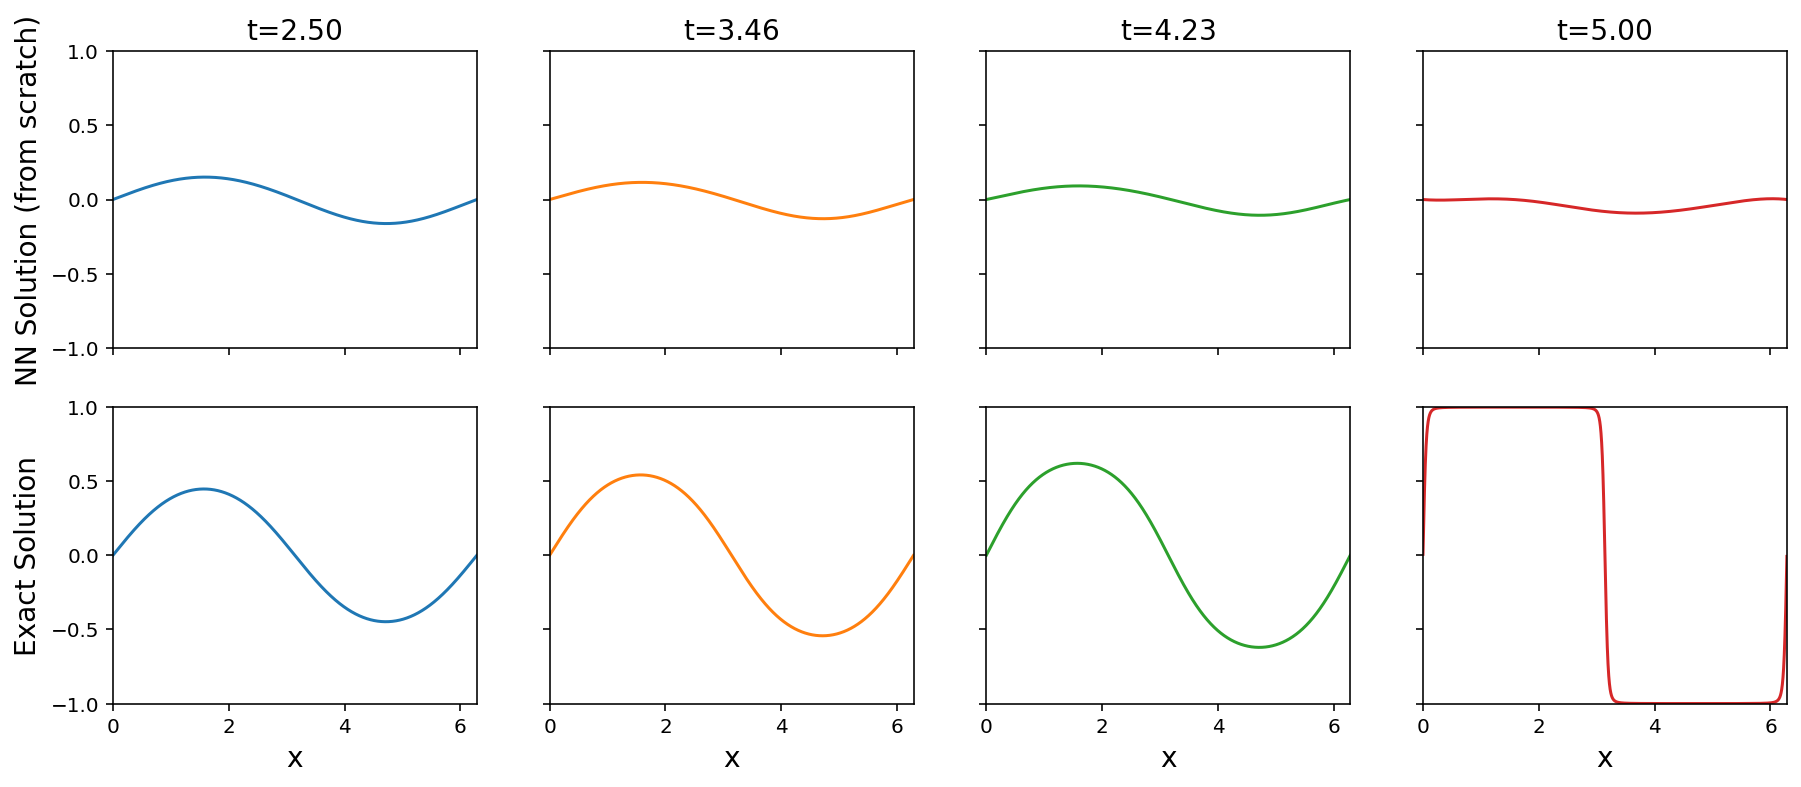

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(15,6))
axs[0, 0].plot(x_axis, u_nn[:,13], 'tab:blue'), axs[0, 0].set_xlim([x_min_p,x_max_p]), axs[0, 0].set_ylim([-1,1]), axs[0, 0].set_title('t=2.50', fontsize=14)
axs[0, 1].plot(x_axis, u_nn[:,18], 'tab:orange'), axs[0, 1].set_xlim([x_min_p,x_max_p]), axs[0, 1].set_ylim([-1,1]), axs[0, 1].set_title('t=3.46', fontsize=14)
axs[0, 2].plot(x_axis, u_nn[:,22], 'tab:green'), axs[0, 2].set_xlim([x_min_p,x_max_p]), axs[0, 2].set_ylim([-1,1]), axs[0, 2].set_title('t=4.23', fontsize=14)
axs[0, 3].plot(x_axis, u_nn[:,nt_p-1], 'tab:red'), axs[0, 3].set_xlim([x_min_p,x_max_p]), axs[0, 3].set_ylim([-1,1]), axs[0, 3].set_title(f't=5.00', fontsize=14)
axs[1, 0].plot(x_axis, sol.T[:,13], 'tab:blue'), axs[1, 0].set_xlim([x_min_p,x_max_p]), axs[1, 0].set_ylim([-1,1])
axs[1, 1].plot(x_axis, sol.T[:,18], 'tab:orange'), axs[1, 1].set_xlim([x_min_p,x_max_p]), axs[1, 1].set_ylim([-1,1])
axs[1, 2].plot(x_axis, sol.T[:,22], 'tab:green'), axs[1, 2].set_xlim([x_min_p,x_max_p]), axs[1, 2].set_ylim([-1,1])
axs[1, 3].plot(x_axis, sol.T[:,nt_p-1], 'tab:red'), axs[1, 3].set_xlim([x_min_p,x_max_p]), axs[1, 3].set_ylim([-1,1])
for ax in axs.flat:
    ax.set_xlabel('x', fontsize=14)
for ax in axs[0, :]:
    ax.set_ylabel('NN Solution (from scratch)', fontsize=14)
for ax in axs[1, :]:
    ax.set_ylabel('Exact Solution', fontsize=14)
for ax in axs.flat:
    ax.label_outer()
plt.show()